## (Slightly More) Advanced Reaction Processing

### 0. Install the necessary Python libraries

In [1]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pandas rdkit mols2grid

### 1. Introduction
In this notebook we'll explore a more complex reaction transform.  I'll go through my thought process and how I set up a reaction like this. The reaction we'll use is the Niementowski quinazoline synthesis.  This is tricky for a few reasons.  
- It involves a ring closure.
- The R3 substituent can be in a variety of positions.
- We would like to enable the reaction to process any ring size for the R3 substituent.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_001.png" alt="Drawing" style="width: 600px;"/>

### 2. Defining the Reaction
We begin by using the [Marvin JS Demo page](https://marvinjs-demo.chemaxon.com/latest/demo.html) to sketch an amide reaction. Notice that the R<sub>1</sub> and R<sub>2</sub> reagents are defined in a standard fashion, I've used a minimal representation for the R<sub>3</sub> aminobenzoic acid.  This way the pattern will match any ring size.  In addition, it will match when the ring is a heterocycle. There a couple of things to notice here.
- The aromatic bond in the thirid reagent.  I do this to match aromatic rings.
- The aromatic bonds in product.  
- Only one ring in the product is specified.  The remaining ring will come from the R<sub>3</sub> reagent.

In MarvinJS, you can make a bond aromatic by holding the mouse over a bond and typing the number "4".

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_002.png" alt="Drawing" style="width: 600px;"/>

### 3. Specifing Hydrogen Counts
First, we need to set the number of allowed hydrogens on each of the reactant hetero atoms.  This will enable us to match primary amines and not secondary amines.  It will also allow us to match carboxylic acids and not esters.  To set the number of hydrogens, right click on an atom and select "Atom Properties". Try this with the nitrogen in the amine reagent on the left. When a dialog like the one below pops up, do the following.
1. Click on the "Advanced Tab"
2. Click the lock to the right of the first field labeled "Total H (H)"
3. Fill in "2" in that field
4. Click "OK".

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_003.png" alt="Drawing" style="width: 300px;"/>

Repeat this process for the other amine, then set the number of hydrogens to "1" for the two acids in the reagents.  After that, your Marvin JS window should look like the figure below. Note the **(H2)** labels on the reagent nitrogens and the **(H1)** labels on the reagent acid oxygens.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_005.png" alt="Drawing" style="width: 600px;"/>

### 4. Atom Mapping the Reaction

In the previous notebook, we used the automapper tool to map the reaction. In this case, we want to be more selective, so we'll manually map the atoms.  To do this, we first selection the reaction arrow tool and drag an arrow from the reactant atom to the corresponding product atom.  For example, draw an arrow from the reactant atom labeled **\[1\]** in the figure below to the corresponding product atom labeled **\[1\]**.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_006.png" alt="Drawing" style="width: 600px;"/>

In a similar fashion we can map the amine nitrogen to the corresponding product atom.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_007.png" alt="Drawing" style="width: 600px;"/>

Now let's map the carboxylic acid.  Note that we don't map either of the oxygens because those atoms don't appear in the product.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_009.png" alt="Drawing" style="width: 600px;"/>

Next, map the aminobenzoic acid. Note that we don't map the hydroxl group on the acid because it isn't in the product.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_010.png" alt="Drawing" style="width: 600px;"/>

Finally, we need to copy the reaction as a reaction SMARTS the RDKit can use.  To do that, we first click on the "Export" icon.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_011.png" alt="Drawing" style="width: 600px;"/>

After clicking on the "Export" icon, a dialog like the one below will pop up.  Change the "Format" menu to "SMARTS" and copy the resulting reaction SMARTS to the clipboard.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/quinaz_012.png" alt="Drawing" style="width: 400px;"/>

Now it's time to write some code. Let's import the necessary Python libraries.

In [14]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import mols2grid
from itertools import product

### 5. Convert the Reaction SMARTS to an RDKit ReactionMol
The SMARTS below is the one we copied from the "Export dialog"

In [15]:
rxn_smarts = "[#6:1]-[#7H2:2].[#6:4]-[#6:3](-[#8H1])=O.[#7H2:5]-[c:6]:[c:7]-[#6:8](-[#8H1])=[O:9]>>[#6:4]-[c:3]1[n:5][c:6][c:7][c:8](=[O:9])[n:2]1-[#6:1]"

Convert the SMARTS to an RDKit ReactionMol.

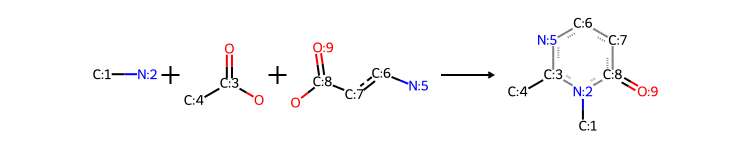

In [16]:
rxn_mol = AllChem.ReactionFromSmarts(rxn_smarts)
rxn_mol

### 6. Read and Process the Reactants
Read the reactants from a csv file.

In [5]:
reagent_df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/data/quinazoline_reagents.csv")

In [17]:
reagent_df

,SMILES,Name,Type,mol
0,CNC(=O)c1n[nH]c(N)n1,19844301,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b1635850>
1,N=C(N)CN1CC[C@H](O)C1,203414649,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b16347b0>
2,COC[C@@H](O)CN,2263862,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b1634e40>
3,NC(=O)CN1CCOCC1,20436848,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b16358c0>
4,CNC(=S)NC(=N)N,33691246,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b1635620>
5,N[C@H]1COC[C@@H]1O,12957834,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b16345f0>
6,CN(C)C[C@@H](N)C(=O)O,35024242,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b16354d0>
7,Nc1nnn(CC(=O)O)n1,4294607,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b16346d0>
8,NC(=O)c1ncc[nH]c1=O,8657,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b1635460>
9,N[C@H](CO)C(=O)O,895342,primary_amine,<rdkit.Chem.rdchem.Mol object at 0x7b62b16355b0>


View the reactants.

In [7]:
mols2grid.display(reagent_df,subset=["img","Type"])

MolGridWidget()

Add an RDKit molecule to **reagent_df**.

In [8]:
reagent_df['mol'] = reagent_df.SMILES.apply(Chem.MolFromSmiles)

### 7. Create the Reactant Inputs
Split **reagent_df** into separate dataframes for each reagent type.

In [9]:
acid_list = reagent_df.query("Type == 'carboxylic_acid'")[["mol","Name"]].values
aminobenzoic_list = reagent_df.query("Type == 'aminobenzoic_acid'")[["mol","Name"]].values
amine_list = reagent_df.query("Type == 'primary_amine'")[["mol","Name"]].values

Now, we'll test the reaction.  **Note that the reactants must be in the same order specified in the reaction SMARTS.** If the reactants are not in the same order, you won't get a a reaction product.

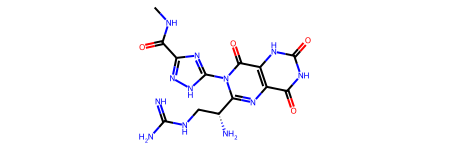

In [10]:
# get the first reagent from each of the 3 lists
test_list = list([x[0][0] for x in [amine_list, acid_list, aminobenzoic_list]])
# run the reaction
product_mol = rxn_mol.RunReactants(test_list)[0][0]
# the reaction product needs to be cleaned up using SanitizeMol
Chem.SanitizeMol(product_mol)
product_mol

### 8. Enumerate the Library
Define a function to enumerate a library.  This is the same function we used in the **reaction_basics** notebook.

In [11]:
def enumerate_library(rxn_mol, reagent_lol):
    prod_list = []
    # itertools.product generates all combinations of reactants
    for reagents in product(*reagent_lol):
        mol_list = [x[0] for x in reagents]
        name_list = [str(x[1]) for x in reagents]
        name = "_".join(name_list)
        prod = rxn_mol.RunReactants(mol_list)
        if prod is not None and len(prod):
            product_mol = prod[0][0]
            Chem.SanitizeMol(product_mol)
            prod_list.append([Chem.MolToSmiles(product_mol), name])
    return prod_list

Enumerate the library and store the resulting SMILES in a dataframe.

In [12]:
prod_list = enumerate_library(rxn_mol, [amine_list, acid_list, aminobenzoic_list])
prod_df = pd.DataFrame(prod_list, columns=["SMILES","Name"])

View the product dataframe.

In [13]:
mols2grid.display(prod_df,subset=["img","Name"])

MolGridWidget()

* In MarvinJS, press "4" on a bond to make it aromatic.

* Do not map atoms (like OH from acids) if they don’t appear in the product.

* Hydrogen count must be set manually to distinguish between:

* Primary vs secondary amines → use Total H = 2

* Acid vs ester → oxygen must have H = 1

* To set H count in MarvinJS:

* Right-click atom → Atom Properties → Advanced → Lock H → Set value

* When using RDKit’s RunReactants(), the order of reactants must match the order in SMARTS — otherwise the reaction may fail or give wrong results.

* Don’t use automapper for complex reactions — do manual atom mapping using arrows.

* In the exported SMARTS, atoms are labeled with numbers like [#6:1] — these must match exactly between reactants and products.

* For ring closures, you don’t need to draw the full ring — just enough to let SMARTS recognize it as aromatic or flexible.

* Use SanitizeMol() after running a reaction to clean up invalid valences or structures.

* To generate all combinations of reagents, use itertools.product() — this allows full library enumeration.

* mols2grid is used just to visually display molecules in a nice grid — optional, but useful.

* For SMARTS export, don’t forget to select “SMARTS” as the format in MarvinJS export dialog.